In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from geofastai import *

## Create a dataframe with image paths

In [3]:
city_imgs = AerialCity('atlanta')
df, n_matches = city_imgs.create_df()
df.head()

['all_sat_LLAHTR', 'all_uav_LLAHTR', 'all_uav_xyzHTR', 'match_array_40', 'sat300_image_paths', 'uav_image_paths']


,uav,sat,label,is_valid
0,train/atlanta/atlanta_uav/uav-small/uav0.png,train/atlanta/atlanta_sat/sat-small/sat0.png,1,False
1,train/atlanta/atlanta_uav/uav-small/uav0.png,train/atlanta/atlanta_sat/sat-small/sat10.png,1,False
2,train/atlanta/atlanta_uav/uav-small/uav0.png,train/atlanta/atlanta_sat/sat-small/sat15.png,1,False
3,train/atlanta/atlanta_uav/uav-small/uav1.png,train/atlanta/atlanta_sat/sat-small/sat1.png,1,False
4,train/atlanta/atlanta_uav/uav-small/uav1.png,train/atlanta/atlanta_sat/sat-small/sat28.png,1,False


In [4]:
mean, std = torch.tensor(imagenet_stats)
# for 3 channels
mean = mean[...,None,None]
std = std  [...,None,None]

## Custom itemlist

In [5]:
# The primary difference from the tutorial is with how normalization is being done here
class ImageTuple(ItemBase):
    def __init__(self, img1, img2):
        self.img1,self.img2 = img1,img2
        self.obj = (img1,img2)
        self.data = [(img1.data-mean)/std, (img2.data-mean)/std]
    def apply_tfms(self, tfms, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms[0], **kwargs)
        self.img2 = self.img2.apply_tfms(tfms[1], **kwargs)
        self.data = [(self.img1.data-mean)/std, (self.img2.data-mean)/std]
        return self    
    def to_one(self): return Image(mean+torch.cat(self.data,2)*std)
    def __repr__(self): return f'{self.__class__.__name__} {self.img1.shape, self.img2.shape}'

In [6]:
class ImageTupleList(ImageList):
    def __init__(self, items, itemsB=None, **kwargs):
        super().__init__(items, **kwargs)
        self.itemsB = itemsB
        self.copy_new.append('itemsB')
    def get(self, i):
        img1 = super().get(i)
        fn = self.itemsB[i]
        return ImageTuple(img1, open_image(fn))
    
    @classmethod
    def from_dfs(cls, df:DataFrame, path='.', cols=0, colsB=1, **kwargs):
        "Create an `ItemList` in `path` from the inputs in the `cols` of `df`."
        t_itemsB = ImageList.from_df(df[df['is_valid']==False], path, colsB).items
        t_res = super().from_df(df[df['is_valid']==False],path,cols, itemsB=t_itemsB, **kwargs)
        v_itemsB = ImageList.from_df(df[df['is_valid']==True],  path, colsB).items
        v_res = super().from_df(df[df['is_valid']==True],path,cols, itemsB=v_itemsB, **kwargs)
        t_res.path = v_res.path = path
        return ItemLists(t_res.path, t_res, v_res)
       
    def reconstruct(self, t:Tensor): 
        return ImageTuple(Image(t[0]*std+mean),Image(t[1]*std+mean))
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(12,6), **kwargs):
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, figsize:Tuple[int,int]=None, **kwargs):
        """Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`.
        `kwargs` are passed to the show method."""
        figsize = ifnone(figsize, (12,3*len(xs)))
        fig,axs = plt.subplots(len(xs), 2, figsize=figsize)
        fig.suptitle('Ground truth / Predictions', weight='bold', size=14)
        for i,(x,z) in enumerate(zip(xs,zs)):
            x.to_one().show(ax=axs[i,0], **kwargs)
            z.to_one().show(ax=axs[i,1], **kwargs)

## Create a databunch

In [7]:
target_col = 2
is_valid_col = 3
bs = 32
data = (ImageTupleList.from_dfs(df, path='.', cols=0, colsB=1)
         .label_from_df(cols=target_col, label_cls=FloatList)
         .databunch(bs=bs))

## Define transforms for random multiple 90 degree rotations

In [8]:
def _rot90_affine(k:partial(uniform_int, 0, 3)):
# adapted from kechan's implementation, see fastai/fastai issue #1653
    "Randomly rotate `x` image based on `k` as in np.rot90"
    #print("k={}".format(k))
    if k%2 == 0:
        x = -1. if k&2 else 1.
        y = -1. if k&2 else 1.
        
        return [[x, 0, 0.],
                [0, y, 0],
                [0, 0, 1.]]
    else:
        x = 1. if k&2 else -1.
        y = -1. if k&2 else 1.
        
        return [[0, x, 0.],
                [y, 0, 0],
                [0, 0, 1.]]

rot90_affine = RandTransform(tfm=TfmAffine(_rot90_affine),
                            kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)

In [9]:
# on satellite apply a dihedral 0,6,3,5 flip => rotate 0,90,180,270
dhf = [0,6,3,5]
tfms_uav = get_transforms(do_flip=False, flip_vert=False)
tfms_sat = get_transforms(do_flip=False, flip_vert=False, 
                          max_warp=None, xtra_tfms=[rot90_affine])

In [10]:
tfms_sat

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rot90_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True

In [11]:
data.train_ds.tfms = [tfms_uav[0], tfms_sat[0]]
data.valid_ds.tfms = [tfms_uav[1], tfms_sat[1]]

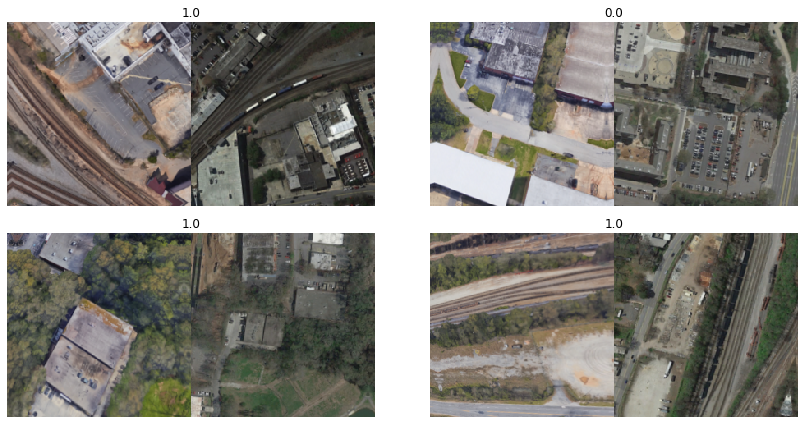

In [12]:
data.show_batch(2, DatasetType.Train)

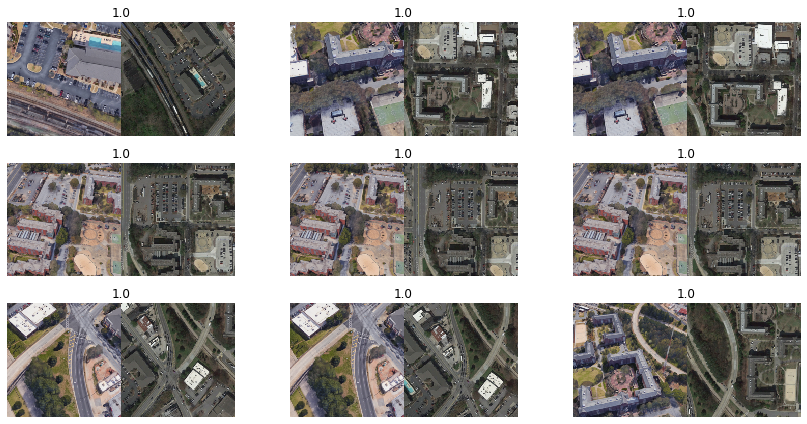

In [13]:
data.show_batch(3, DatasetType.Valid)

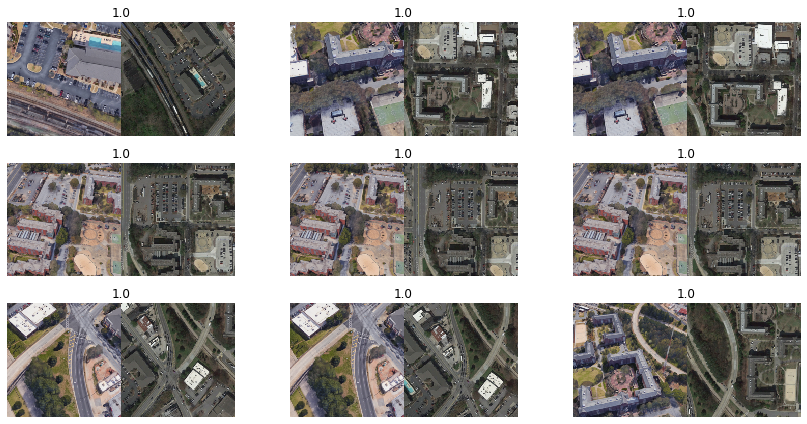

In [14]:
data.show_batch(3, DatasetType.Valid)

In [15]:
df[df['is_valid']==True][0:10]

,uav,sat,label,is_valid
3116,train/atlanta/atlanta_uav/uav-small/uav1642.png,train/atlanta/atlanta_sat/sat-small/sat1642.png,1,True
3117,train/atlanta/atlanta_uav/uav-small/uav1643.png,train/atlanta/atlanta_sat/sat-small/sat1643.png,1,True
3118,train/atlanta/atlanta_uav/uav-small/uav1643.png,train/atlanta/atlanta_sat/sat-small/sat1671.png,1,True
3119,train/atlanta/atlanta_uav/uav-small/uav1644.png,train/atlanta/atlanta_sat/sat-small/sat1284.png,1,True
3120,train/atlanta/atlanta_uav/uav-small/uav1644.png,train/atlanta/atlanta_sat/sat-small/sat1309.png,1,True
3121,train/atlanta/atlanta_uav/uav-small/uav1644.png,train/atlanta/atlanta_sat/sat-small/sat1644.png,1,True
3122,train/atlanta/atlanta_uav/uav-small/uav1645.png,train/atlanta/atlanta_sat/sat-small/sat1645.png,1,True
3123,train/atlanta/atlanta_uav/uav-small/uav1645.png,train/atlanta/atlanta_sat/sat-small/sat1655.png,1,True
3124,train/atlanta/atlanta_uav/uav-small/uav1646.png,train/atlanta/atlanta_sat/sat-small/sat1646.png,1,True
3125,train/atlanta/atlanta_uav/uav-small/uav1646.png,train/atlanta/atlanta_sat/sat-small/sat1674.png,1,True


## Train for some epochs to see how it is going 
### Model

In [16]:
class DualResNet18(nn.Module):
    def __init__(self, arch = models.resnet18):
        super().__init__()
        self.GEcnn  = create_body(arch)
        self.GEhead = nn.Sequential(AdaptiveConcatPool2d(1), 
                                    Flatten(),
                                    nn.BatchNorm1d(1024),
                                    nn.Dropout(p=0.25, inplace=False),
                                    nn.Linear(in_features=1024, out_features=512, bias=True),
                                    nn.ReLU(inplace=True),
                                    nn.BatchNorm1d(512),
                                    nn.Dropout(p=0.5, inplace=False),
                                    nn.Linear(in_features=512, out_features=512, bias=True))     
        self.GMcnn  = create_body(arch)
        self.GMhead = nn.Sequential(AdaptiveConcatPool2d(1), 
                                    Flatten(),
                                    nn.BatchNorm1d(1024),
                                    nn.Dropout(p=0.25, inplace=False),
                                    nn.Linear(in_features=1024, out_features=512, bias=True),
                                    nn.ReLU(inplace=True),
                                    nn.BatchNorm1d(512),
                                    nn.Dropout(p=0.5, inplace=False),
                                    nn.Linear(in_features=512, out_features=512, bias=True))
        
    def forward(self, img1, img2):
        o1 = self.GEhead(self.GEcnn(img1))
        o2 = self.GMhead(self.GMcnn(img2))
        output = torch.norm(o1-o2, p=2, dim=1)
        return output

### Loss 

In [17]:
def loss_contrastive(euclidean_distance, label_batch):
    margin = 100
    loss = torch.mean( (label_batch) * torch.pow(euclidean_distance, 2) +
                    (1-label_batch) * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2))
    return loss

### Learn 

In [18]:
model = DualResNet18()
learn = Learner(data, model, loss_func=loss_contrastive)

In [19]:
learn.summary()

DualResNet18
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
_________________________________________________

In [20]:
learn.split([[learn.model.GEcnn[:6], learn.model.GMcnn[:6]], 
             [learn.model.GEcnn[6:], learn.model.GMcnn[6:]],
             [learn.model.GEhead,    learn.model.GMhead]])

Learner(data=ImageDataBunch;

Train: LabelList (6232 items)
x: ImageTupleList
ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224]))
y: FloatList
1.0,1.0,1.0,1.0,1.0
Path: .;

Valid: LabelList (1560 items)
x: ImageTupleList
ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224]))
y: FloatList
1.0,1.0,1.0,1.0,1.0
Path: .;

Test: None, model=DualResNet18(
  (GEcnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3),

In [21]:
learn.freeze()

In [22]:
learn.summary()

DualResNet18
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        False     
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        False     
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
_________________________________________________

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-04
Min loss divided by 10: 2.29E-03


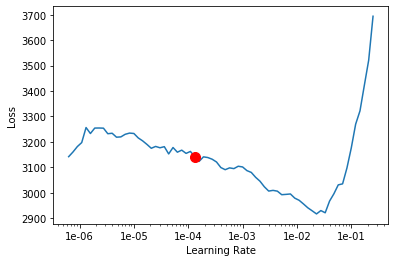

In [23]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [24]:
lr = 2e-3
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,time
0,2317.554199,2206.920166,02:55
1,1845.956421,2027.782959,02:55
2,1680.048218,1916.390015,02:53
3,1570.856812,1874.229126,02:56
4,1466.516602,1854.360718,02:55


In [25]:
learn.freeze_to(-2)
learn.summary()

DualResNet18
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        False     
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        False     
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
_________________________________________________

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.98E-05


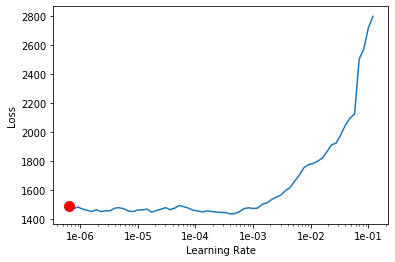

In [26]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [27]:
learn.fit_one_cycle(5, slice(1e-4))

epoch,train_loss,valid_loss,time
0,1417.972168,1842.428833,05:42
1,1354.915405,1825.089233,05:29
2,1280.513184,1847.312866,05:03
3,1231.973511,1853.392822,05:28
4,1203.095825,1823.036743,05:29


In [28]:
learn.unfreeze()
learn.summary()

DualResNet18
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
_________________________________________________

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.32E-07


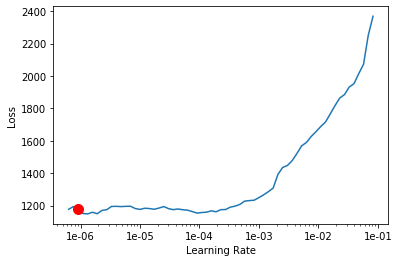

In [29]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [30]:
learn.fit_one_cycle(5, slice(1e-6,1e-4/3))

epoch,train_loss,valid_loss,time
0,1205.142090,1789.073853,08:42
1,1198.905151,1781.799561,08:29
2,1119.520264,1801.480347,08:49
3,1151.296997,1839.922241,08:30
4,1124.666260,1763.532837,08:21


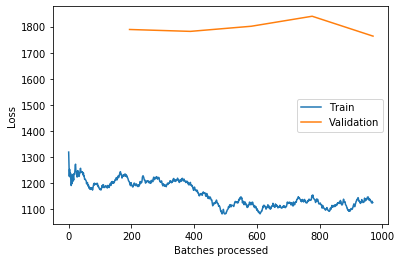

In [31]:
learn.recorder.plot_losses()

In [32]:
def histo(preds, dset):
    matdist, nmatdist = [], []
    for i in range(len(preds[0])):
        if preds[1][i] == 0: nmatdist.append(preds[0][i].numpy())
        if preds[1][i] == 1: matdist. append(preds[0][i].numpy())

    mathist  = plt.hist( matdist, range(int(np.ceil(max( matdist)))), label = 'matching pairs', alpha = 0.7)
    nmathist = plt.hist(nmatdist, range(int(np.ceil(max(nmatdist)))), label = 'non-matching pairs', alpha = 0.7)
    plt.legend(loc='best')
    plt.title(dset + ' data')
    plt.xlabel('Distance between image pairs')
    plt.show()

In [33]:
preds = learn.get_preds(DatasetType.Train)
len(preds), preds[0].shape, preds

(2,
 torch.Size([6208]),
 [tensor([ 90.2455,  27.5062,  30.4001,  ..., 109.3341,  93.5919, 129.4218]),
  tensor([0., 1., 1.,  ..., 0., 0., 0.])])

In [34]:
v_preds = learn.get_preds(DatasetType.Valid)
len(v_preds), v_preds[0].shape, v_preds

(2,
 torch.Size([1560]),
 [tensor([ 34.2855,  47.5902,  48.9504,  ..., 104.6659,  67.4361, 135.2600]),
  tensor([1., 1., 1.,  ..., 0., 0., 0.])])

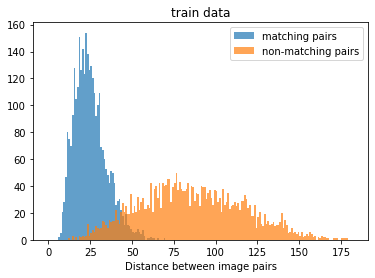

In [35]:
histo(preds, 'train')

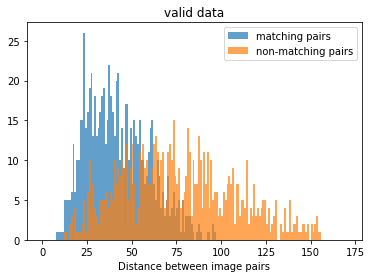

In [36]:
histo(v_preds, 'valid')

In [38]:
get_transforms()

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do